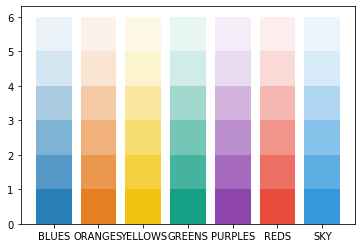

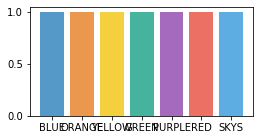

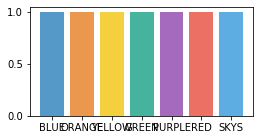

<Figure size 288x144 with 0 Axes>

In [5]:
from process_helper import *
import numpy as np
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(4)
_, line_colors = select_color_idx(4)
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5
datadir = "../output/"

In [2]:
data = [line.strip().split(",") for line in open(datadir + "microbench_latency" + ".txt")]
df = pd.DataFrame(data, columns=["op", "payload", "latency", "unit"])
df["latency"] = df["latency"].astype("float")
df["payload"] = df["payload"].astype("int")

In [3]:
filterd = apply_mask(df, [
    ["payload", ["ne", 8192]],
    ["payload", ["lt", 100000]],
    ["payload", ["ne", 1]],
    ["payload", ["ne", 83]],
])
pivot = filterd.groupby(["op", "payload"])["latency"].mean()

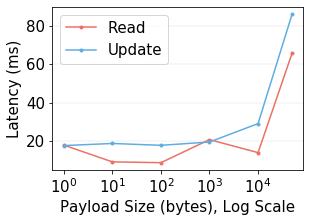

In [86]:
fig, ax = plt.subplots(1, 1)
xvals = pivot.loc["read"].index
ax.plot(xvals, pivot.loc["read"] / 1000.0,
        color=line_colors["RED"],
        marker=".", label="Read")
# ax.plot(pivot.loc["scan"].index, pivot.loc["scan"],
#         color=line_colors["PURPLE"],
#         marker=".", label="scan")
ax.plot(xvals, pivot.loc["write"] / 1000.0,
       color=line_colors["SKYS"],
        marker=".", label="Update")
ax.legend()
ax.set_xscale("log")
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.set_xlabel("Payload Size (bytes), Log Scale")
ax.set_ylabel("Latency (ms)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
fig.set_size_inches(4.5, 3)
path = "/Users/scarlet/Desktop/Bonsai/figures/"
fig.savefig(path + "micro_payload_latency.pdf", bbox_inches="tight") 

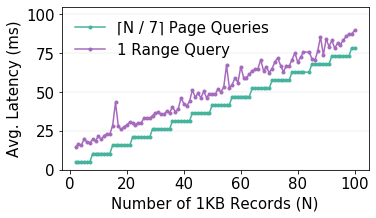

In [8]:
import math
def format_ticks(value, pos):
    if value % 1000 == 0:
        return f'{int(value/1000)}k'
    else:
        return int(value)
fig, ax = plt.subplots(1, 1)
pg = 5.24
pg_sz = 8192
xvals = pivot.loc["scan"].index
# math.ceil(x / 1000 * 1008.0 / pg_sz)
pg_latency = np.array([math.ceil(x / 7.0) * pg for x in xvals])
ax.plot(xvals, pg_latency,
        color=line_colors["GREEN"],
        marker=".", label="⌈N / 7⌉ Page Queries")
ax.plot(xvals, pivot.loc["scan"] / 1000.0,
        color=line_colors["PURPLE"],
        marker=".", label="1 Range Query")
ax.legend(frameon=False)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_ticks))
ax.set_xlabel("Number of 1KB Records (N)")
ax.set_ylabel("Avg. Latency (ms)")
ax.set_ylim(0, 105)
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.25)
fig.set_size_inches(5.5, 3)
path = "/Users/scarlet/Desktop/Bonsai/figures/"
fig.savefig(path + "scan_latency.pdf", bbox_inches="tight") 

In [73]:
xvals

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
             15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
             28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
             41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
             54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
             67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
             80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
             94,  95,  96,  97,  98,  99, 100],
           dtype='int64', name='payload')

In [81]:
y1 = (pivot.loc["scan"] / 1000.0)#[:60]
y2 = pg_latency#[:60]
x = xvals#[:60]

In [75]:
from scipy import stats
def cal_linear_regression(x, y):
    z_score_threshold = 2.0

    # Calculate z-scores for the 'y' data
    z_scores = np.abs(stats.zscore(y))

    # Create a mask to filter out data points with z-scores beyond the threshold
    outlier_mask = z_scores < z_score_threshold

    # Apply the mask to 'x' and 'y' data
    x_filtered = x[outlier_mask]
    y_filtered = y[outlier_mask]

    # Calculate linear regression for the filtered data
    coefficients = np.polyfit(x_filtered, y_filtered, 1)
    slope, intercept = coefficients
    print("y = %.2fx + %.2f" % (slope, intercept))
    return slope, intercept

#     # Create a DataFrame for results
#     result_df = pd.DataFrame({'x': x_filtered, 'y': y_filtered})

#     # Add a column for the predicted values
#     result_df['y_predicted'] = slope * x_filtered + intercept

#     # Calculate the residuals
#     result_df['residuals'] = result_df['y'] - result_df['y_predicted']

#     # Print the results
#     print("Linear Regression Results (After Removing Outliers):")
#     print(result_df)

#     # Optional: You can also calculate the R-squared value
#     correlation_matrix = np.corrcoef(x_filtered, y_filtered)
#     r_squared = correlation_matrix[0, 1] ** 2
#     print("R-squared:", r_squared)

In [82]:
model1 = cal_linear_regression(x, y1)

y = 0.73x + 14.26


In [83]:
model2 = cal_linear_regression(x, y2)

y = 0.75x + 2.25


In [84]:
def predict(x, model):
    return model[0] * x + model[1]

In [85]:
predict(8.21, model1)

20.255219354821918

In [86]:
predict(16.81, model2)

14.8390128695702